In [ ]:
!pip install pyspark


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
matplotlib.style.use('ggplot')

CO2 DATABASE

In [ ]:
df = pd.read_csv('owid-co2-data.csv')
weather = pd.read_csv('GlobalLandTemperaturesByCountry.csv')
crops = pd.read_csv('psd_grains_pulses.csv')
d = df.sample(n = len(df))
d.head()

,iso_code,country,year,co2,co2_per_capita,trade_co2,cement_co2,cement_co2_per_capita,coal_co2,coal_co2_per_capita,...,ghg_excluding_lucf_per_capita,methane,methane_per_capita,nitrous_oxide,nitrous_oxide_per_capita,population,gdp,primary_energy_consumption,energy_per_capita,energy_per_gdp
11098,IDN,Indonesia,2009,401.957,1.684,1.971,19.437,0.082,128.274,0.538,...,3.118,362.20,1.518,82.52,0.346,238620554.0,1.886335e+12,1599.397,6702.667,1.059
12736,KGZ,Kyrgyzstan,2018,11.698,1.856,6.217,0.753,0.120,4.041,0.641,...,2.874,4.99,0.792,1.99,0.316,6304025.0,2.960115e+10,NaN,NaN,NaN
15158,MOZ,Mozambique,1940,0.066,0.013,NaN,0.015,0.003,0.051,0.010,...,NaN,NaN,NaN,NaN,NaN,4998077.0,NaN,NaN,NaN,NaN
5451,CUW,Curacao,1976,17.589,117.074,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,150240.0,NaN,NaN,NaN,NaN
23545,ARE,United Arab Emirates,2003,105.619,28.454,23.425,2.909,0.784,0.421,0.114,...,37.530,30.16,8.125,4.16,1.121,3711931.0,2.217949e+11,634.856,171027.983,1.856


FEATURE SELECTION AND PREPROCESSING

Correlation Heatmaps

In [ ]:
sns.set(rc ={'figure.figsize':(30,30)})
axes = plt.axes()
sns.heatmap(df.corr(method = 'pearson'))
axes.set_title("CO2 EMISSIONS", fontsize = 20)

In [ ]:
dfe = df.drop(df.iloc[:, 23:46], axis = 1)

In [ ]:
sns.set(rc ={'figure.figsize':(24,24)})
axes = plt.axes()
sns.heatmap(dfe.corr(method = 'pearson'))
axes.set_title("CO2 EMISSIONS", fontsize = 20)

In [ ]:
dfe

In [ ]:
dfe2 = dfe.drop(dfe.columns[[3,4,7,9,11,13,15,17,18,19,20,21,23,25,27,29,31,35,36]], axis = 1)

In [ ]:
dfe2

In [ ]:
sns.set(rc ={'figure.figsize':(24,24)})
axes = plt.axes()
sns.heatmap(dfe2.corr(method = 'pearson'))
axes.set_title("CO2 EMISSIONS", fontsize = 20)

In [ ]:
dfe2.var(skipna = True, numeric_only= None)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


year                          2.893251e+03
trade_co2                     3.328616e+04
cement_co2                    5.968886e+03
coal_co2                      6.179640e+05
flaring_co2                   1.637981e+03
gas_co2                       1.945379e+05
oil_co2                       3.632275e+05
other_industry_co2            1.551225e+03
consumption_co2               1.137948e+07
total_ghg                     8.736162e+06
total_ghg_excluding_lucf      8.223739e+06
methane                       2.970408e+05
nitrous_oxide                 3.926253e+04
population                    1.440003e+17
gdp                           4.752811e+24
primary_energy_consumption    8.219422e+07
dtype: float64

In [ ]:
dfe2.shape

In [ ]:
dfvar = dfe2.drop(['country','iso_code'], axis = 1)
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold = .5)
selection = selector.fit_transform(dfvar)
selection

In [ ]:
selection.shape

In [ ]:
dfe2.isnull().sum()

iso_code                       3231
country                           0
year                              0
trade_co2                     21215
cement_co2                    12943
coal_co2                       8003
flaring_co2                   20809
gas_co2                       16346
oil_co2                        4652
other_industry_co2            23192
consumption_co2               21215
total_ghg                     19540
total_ghg_excluding_lucf      19540
methane                       19536
nitrous_oxide                 19536
population                     2299
gdp                           11653
primary_energy_consumption    16501
dtype: int64

In [ ]:
dfe2.iloc[:, 3:15] = dfe2.iloc[:, 3:15].fillna(0)

In [ ]:
dfe2.isnull().sum()

iso_code                       3231
country                           0
year                              0
trade_co2                         0
cement_co2                        0
coal_co2                          0
flaring_co2                       0
gas_co2                           0
oil_co2                           0
other_industry_co2                0
consumption_co2                   0
total_ghg                         0
total_ghg_excluding_lucf          0
methane                           0
nitrous_oxide                     0
population                     2299
gdp                           11653
primary_energy_consumption    16501
dtype: int64

Steps toward Integrating into One Final Dataset

In [ ]:
yearIndex = dfe2[dfe2['year'] < 1960].index
yearIndex2 = dfe2[dfe2['year'] > 2012].index

In [ ]:
dfe2.count()

iso_code                      21960
country                       25191
year                          25191
trade_co2                     25191
cement_co2                    25191
coal_co2                      25191
flaring_co2                   25191
gas_co2                       25191
oil_co2                       25191
other_industry_co2            25191
consumption_co2               25191
total_ghg                     25191
total_ghg_excluding_lucf      25191
methane                       25191
nitrous_oxide                 25191
population                    22892
gdp                           13538
primary_energy_consumption     8690
dtype: int64

In [ ]:
dfe3 = dfe2.drop(yearIndex)

In [ ]:
dfe4 = dfe3.drop(yearIndex2)

In [ ]:
dfe4.count()

iso_code                      11093
country                       12263
year                          12263
trade_co2                     12263
cement_co2                    12263
coal_co2                      12263
flaring_co2                   12263
gas_co2                       12263
oil_co2                       12263
other_industry_co2            12263
consumption_co2               12263
total_ghg                     12263
total_ghg_excluding_lucf      12263
methane                       12263
nitrous_oxide                 12263
population                    11478
gdp                            8362
primary_energy_consumption     7605
dtype: int64

In [ ]:
dfe4.head()

,iso_code,country,year,trade_co2,cement_co2,coal_co2,flaring_co2,gas_co2,oil_co2,other_industry_co2,consumption_co2,total_ghg,total_ghg_excluding_lucf,methane,nitrous_oxide,population,gdp,primary_energy_consumption
11,AFG,Afghanistan,1960,0.0,0.018,0.127,0.0,0.0,0.269,0.0,0.0,0.0,0.0,0.0,0.0,8996967.0,1.303325e+10,NaN
12,AFG,Afghanistan,1961,0.0,0.022,0.176,0.0,0.0,0.293,0.0,0.0,0.0,0.0,0.0,0.0,9169406.0,1.314629e+10,NaN
13,AFG,Afghanistan,1962,0.0,0.029,0.297,0.0,0.0,0.363,0.0,0.0,0.0,0.0,0.0,0.0,9351442.0,1.336763e+10,NaN
14,AFG,Afghanistan,1963,0.0,0.051,0.264,0.0,0.0,0.392,0.0,0.0,0.0,0.0,0.0,0.0,9543200.0,1.363030e+10,NaN
15,AFG,Afghanistan,1964,0.0,0.062,0.300,0.0,0.0,0.476,0.0,0.0,0.0,0.0,0.0,0.0,9744772.0,1.387050e+10,NaN


In [ ]:
isoIndex = dfe4[dfe4['iso_code'].isnull()].index

In [ ]:
dfe5 = dfe4.drop(isoIndex)

In [ ]:
dfe5.shape

(11093, 18)

In [ ]:
dfe5.head()

,iso_code,country,year,trade_co2,cement_co2,coal_co2,flaring_co2,gas_co2,oil_co2,other_industry_co2,consumption_co2,total_ghg,total_ghg_excluding_lucf,methane,nitrous_oxide,population,gdp,primary_energy_consumption
11,AFG,Afghanistan,1960,0.0,0.018,0.127,0.0,0.0,0.269,0.0,0.0,0.0,0.0,0.0,0.0,8996967.0,1.303325e+10,NaN
12,AFG,Afghanistan,1961,0.0,0.022,0.176,0.0,0.0,0.293,0.0,0.0,0.0,0.0,0.0,0.0,9169406.0,1.314629e+10,NaN
13,AFG,Afghanistan,1962,0.0,0.029,0.297,0.0,0.0,0.363,0.0,0.0,0.0,0.0,0.0,0.0,9351442.0,1.336763e+10,NaN
14,AFG,Afghanistan,1963,0.0,0.051,0.264,0.0,0.0,0.392,0.0,0.0,0.0,0.0,0.0,0.0,9543200.0,1.363030e+10,NaN
15,AFG,Afghanistan,1964,0.0,0.062,0.300,0.0,0.0,0.476,0.0,0.0,0.0,0.0,0.0,0.0,9744772.0,1.387050e+10,NaN


In [ ]:
w_country = weather['Country'].unique()
print(w_country)

['Åland' 'Afghanistan' 'Africa' 'Albania' 'Algeria' 'American Samoa'
 'Andorra' 'Angola' 'Anguilla' 'Antarctica' 'Antigua And Barbuda'
 'Argentina' 'Armenia' 'Aruba' 'Asia' 'Australia' 'Austria' 'Azerbaijan'
 'Bahamas' 'Bahrain' 'Baker Island' 'Bangladesh' 'Barbados' 'Belarus'
 'Belgium' 'Belize' 'Benin' 'Bhutan' 'Bolivia'
 'Bonaire, Saint Eustatius And Saba' 'Bosnia And Herzegovina' 'Botswana'
 'Brazil' 'British Virgin Islands' 'Bulgaria' 'Burkina Faso' 'Burma'
 'Burundi' "Côte D'Ivoire" 'Cambodia' 'Cameroon' 'Canada' 'Cape Verde'
 'Cayman Islands' 'Central African Republic' 'Chad' 'Chile' 'China'
 'Christmas Island' 'Colombia' 'Comoros'
 'Congo (Democratic Republic Of The)' 'Congo' 'Costa Rica' 'Croatia'
 'Cuba' 'Curaçao' 'Cyprus' 'Czech Republic' 'Denmark (Europe)' 'Denmark'
 'Djibouti' 'Dominica' 'Dominican Republic' 'Ecuador' 'Egypt'
 'El Salvador' 'Equatorial Guinea' 'Eritrea' 'Estonia' 'Ethiopia' 'Europe'
 'Falkland Islands (Islas Malvinas)' 'Faroe Islands'
 'Federated States Of

In [ ]:
co2_country = dfe4['country'].unique()
print(co2_country)

['Afghanistan' 'Africa' 'Albania' 'Algeria' 'Andorra' 'Angola' 'Anguilla'
 'Antarctica' 'Antigua and Barbuda' 'Argentina' 'Armenia' 'Aruba' 'Asia'
 'Asia (excl. China & India)' 'Australia' 'Austria' 'Azerbaijan' 'Bahamas'
 'Bahrain' 'Bangladesh' 'Barbados' 'Belarus' 'Belgium' 'Belize' 'Benin'
 'Bermuda' 'Bhutan' 'Bolivia' 'Bonaire Sint Eustatius and Saba'
 'Bosnia and Herzegovina' 'Botswana' 'Brazil' 'British Virgin Islands'
 'Brunei' 'Bulgaria' 'Burkina Faso' 'Burundi' 'Cambodia' 'Cameroon'
 'Canada' 'Cape Verde' 'Central African Republic' 'Chad' 'Chile' 'China'
 'Christmas Island' 'Colombia' 'Comoros' 'Congo' 'Cook Islands'
 'Costa Rica' "Cote d'Ivoire" 'Croatia' 'Cuba' 'Curacao' 'Cyprus'
 'Czechia' 'Democratic Republic of Congo' 'Denmark' 'Djibouti' 'Dominica'
 'Dominican Republic' 'EU-27' 'EU-28' 'Ecuador' 'Egypt' 'El Salvador'
 'Equatorial Guinea' 'Eritrea' 'Estonia' 'Eswatini' 'Ethiopia' 'Europe'
 'Europe (excl. EU-27)' 'Europe (excl. EU-28)' 'Faeroe Islands' 'Fiji'
 'Finland' 'F

In [ ]:
crop_country = crops['Country_Name'].unique()
print(crop_country)

['Afghanistan' 'Albania' 'Algeria' 'Argentina' 'Armenia' 'Australia'
 'Azerbaijan' 'Bangladesh' 'Belarus' 'Bhutan' 'Bolivia'
 'Bosnia and Herzegovina' 'Brazil' 'Bulgaria' 'Canada' 'Chile' 'China'
 'Colombia' 'Croatia' 'Cuba' 'Cyprus' 'Czech Republic' 'Ecuador' 'Egypt'
 'Eritrea' 'Estonia' 'Ethiopia' 'EU-15' 'European Union'
 'Former Czechoslovakia' 'Former Yugoslavia' 'Georgia' 'Hungary' 'Iceland'
 'India' 'Iran' 'Iraq' 'Israel' 'Japan' 'Jordan' 'Kazakhstan' 'Kenya'
 'Korea, South' 'Kuwait' 'Kyrgyzstan' 'Latvia' 'Lebanon' 'Libya'
 'Lithuania' 'Malta' 'Mexico' 'Moldova' 'Morocco' 'Nepal' 'New Zealand'
 'North Macedonia' 'Norway' 'Oman' 'Pakistan' 'Peru' 'Poland' 'Qatar'
 'Romania' 'Russia' 'Saudi Arabia' 'Serbia' 'Serbia and Montenegro'
 'Singapore' 'Slovakia' 'Slovenia' 'South Africa' 'Switzerland' 'Syria'
 'Taiwan' 'Tajikistan' 'Thailand' 'Tunisia' 'Turkey' 'Turkmenistan'
 'Ukraine' 'Union of Soviet Socialist Repu' 'United Arab Emirates'
 'United Kingdom' 'United States' 'Uruguay' 'Uz

In [ ]:
country_list = [w_country, co2_country, crop_country]
country_list

[array(['Åland', 'Afghanistan', 'Africa', 'Albania', 'Algeria',
        'American Samoa', 'Andorra', 'Angola', 'Anguilla', 'Antarctica',
        'Antigua And Barbuda', 'Argentina', 'Armenia', 'Aruba', 'Asia',
        'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
        'Baker Island', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium',
        'Belize', 'Benin', 'Bhutan', 'Bolivia',
        'Bonaire, Saint Eustatius And Saba', 'Bosnia And Herzegovina',
        'Botswana', 'Brazil', 'British Virgin Islands', 'Bulgaria',
        'Burkina Faso', 'Burma', 'Burundi', "Côte D'Ivoire", 'Cambodia',
        'Cameroon', 'Canada', 'Cape Verde', 'Cayman Islands',
        'Central African Republic', 'Chad', 'Chile', 'China',
        'Christmas Island', 'Colombia', 'Comoros',
        'Congo (Democratic Republic Of The)', 'Congo', 'Costa Rica',
        'Croatia', 'Cuba', 'Curaçao', 'Cyprus', 'Czech Republic',
        'Denmark (Europe)', 'Denmark', 'Djibouti', 'Dominica',
        'Dominican

In [ ]:
from functools import reduce
values = reduce(np.intersect1d, country_list)

In [ ]:
dfe6 = dfe5[dfe5.country.isin(values) == True]

In [ ]:
dfe6.shape

(7122, 18)

In [ ]:
dfe6['country'].describe()

count            7122
unique            136
top       Afghanistan
freq               53
Name: country, dtype: object

In [ ]:
dfe6.describe()

,year,trade_co2,cement_co2,coal_co2,flaring_co2,gas_co2,oil_co2,other_industry_co2,consumption_co2,total_ghg,total_ghg_excluding_lucf,methane,nitrous_oxide,population,gdp,primary_energy_consumption
count,7122.000000,7122.000000,7122.000000,7122.000000,7122.000000,7122.000000,7122.000000,7122.000000,7122.000000,7122.000000,7122.000000,7122.000000,7122.00000,7.122000e+03,6.468000e+03,5046.000000
mean,1986.175372,-2.082756,3.419257,52.064254,1.823128,21.960987,48.186187,0.823896,69.520412,103.036366,98.847355,21.508151,7.48747,3.359136e+07,2.828359e+11,696.553759
std,15.275985,62.164920,22.909689,293.885298,6.104696,106.228880,203.902368,6.635128,447.032200,539.531127,564.047890,89.258088,31.92846,1.225490e+08,1.090678e+12,2692.561378
min,1960.000000,-1517.839000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-168.240000,0.000000,0.000000,0.00000,4.738300e+04,4.536570e+08,0.033000
25%,1973.000000,0.000000,0.036000,0.000000,0.000000,0.000000,1.341000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,2.937769e+06,1.114820e+10,15.819250
50%,1986.000000,0.000000,0.311500,0.168000,0.000000,0.073000,5.078000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,6.835554e+06,3.320313e+10,72.840000
75%,1999.000000,0.000000,1.460000,5.047250,0.238000,6.269250,23.245750,0.000000,5.725750,31.167500,25.680000,8.195000,3.38000,1.953375e+07,1.325306e+11,314.856250
max,2012.000000,543.504000,714.782000,7464.806000,75.185000,1388.255000,2608.477000,141.722000,8367.184000,10690.040000,11399.830000,1151.280000,504.17000,1.384206e+09,1.584964e+13,32512.623000


In [ ]:
dfe6.to_csv('owid-co2-data-final.csv')

VISUALIZATIONS BELOW

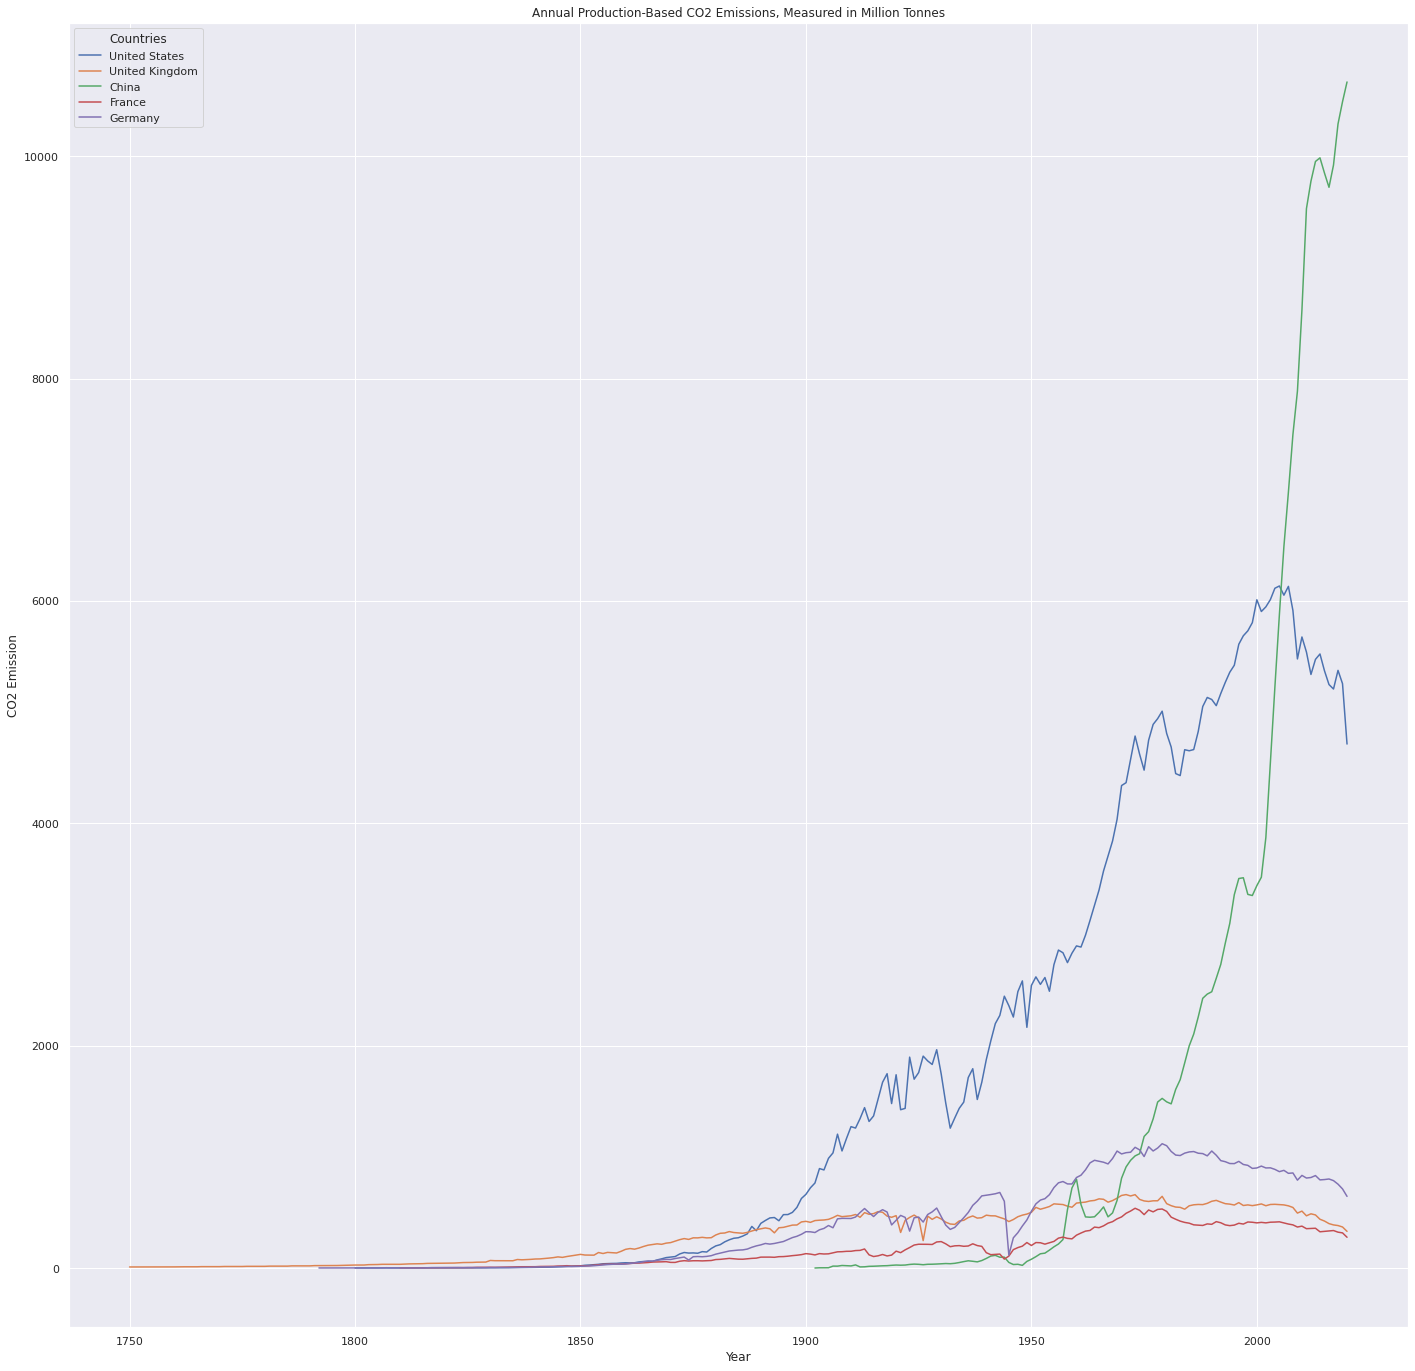

In [ ]:
d = df.loc[(df['country'] == 'United States')]
s = df.loc[(df['country'] == 'United Kingdom')]
c = df.loc[(df['country'] == 'China')]
f = df.loc[(df['country'] == 'France')]
g = df.loc[(df['country'] == 'Germany')]

plt.plot(d['year'], d['co2'], s['year'], s['co2'], c['year'], c['co2'], f['year'], f['co2'], g['year'], g['co2'])
plt.xlabel('Year')
plt.ylabel('CO2 Emission')
plt.legend( ['United States', 'United Kingdom', 'China', 'France', 'Germany'], title = 'Countries')
plt.title('Annual Production-Based CO2 Emissions, Measured in Million Tonnes')
plt.show()

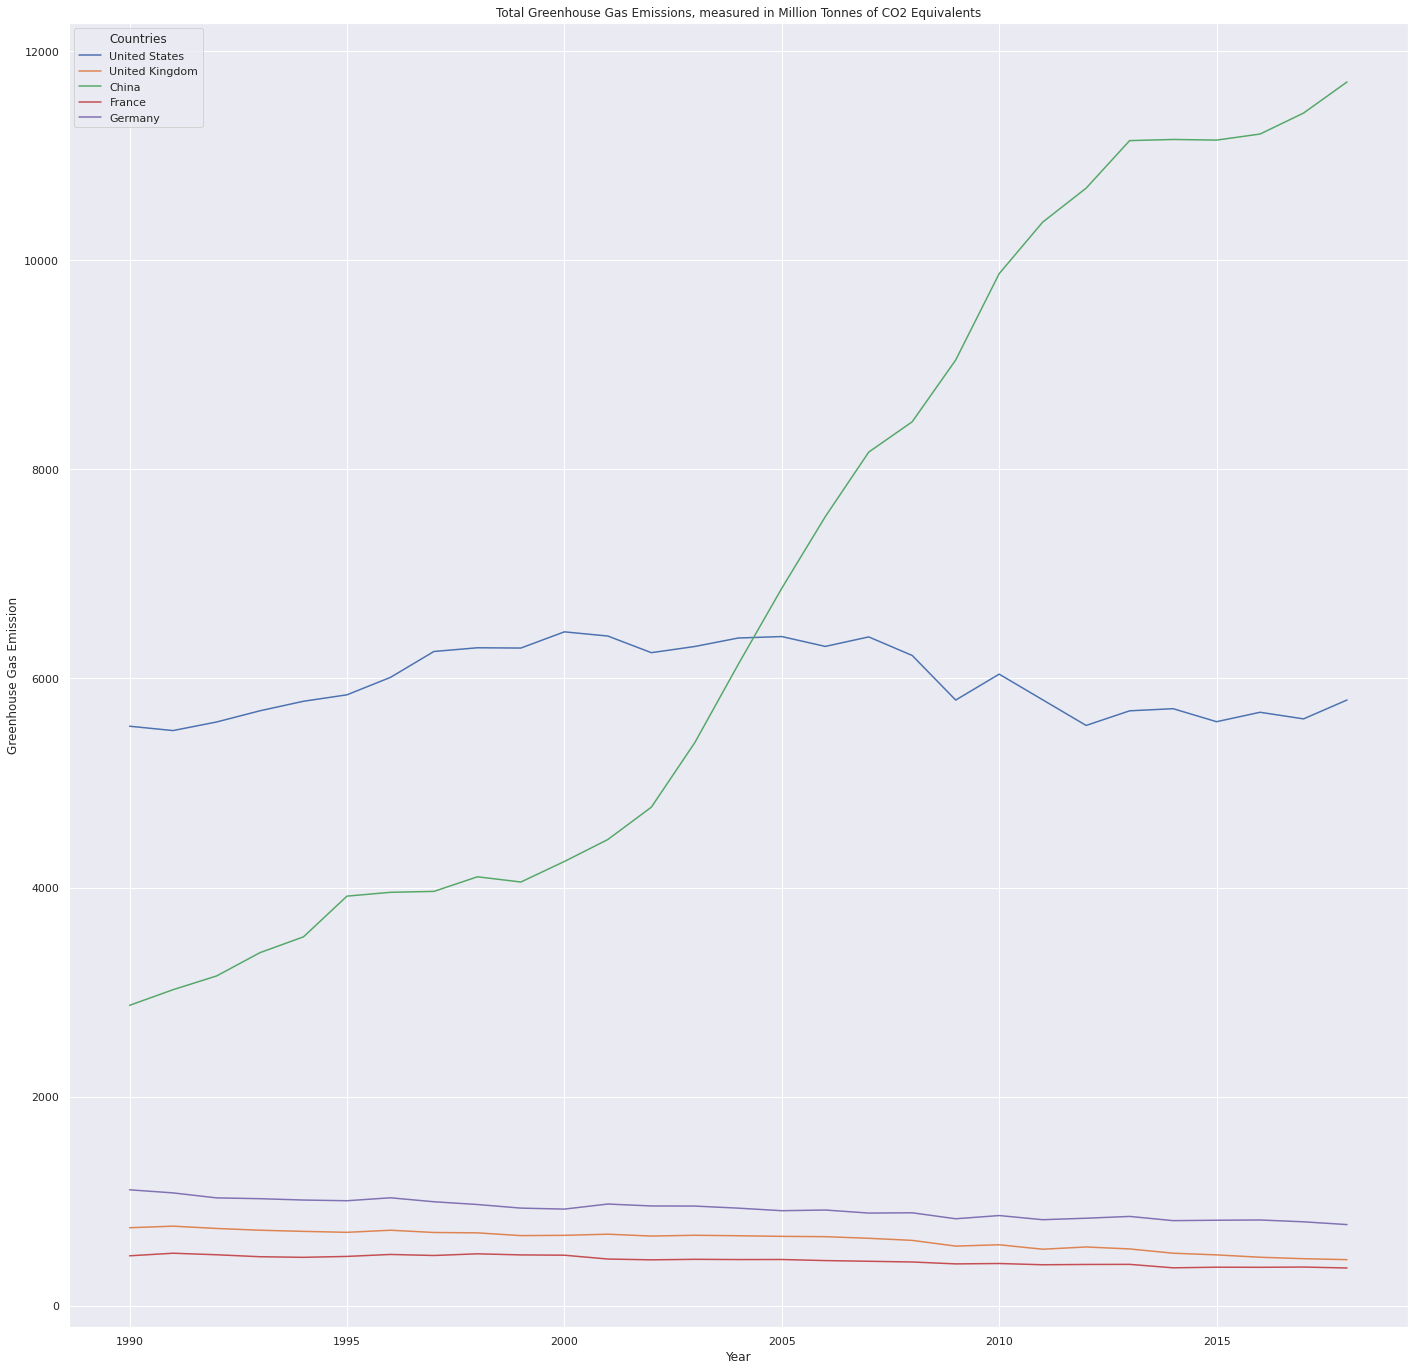

In [ ]:
plt.plot(d['year'], d['total_ghg'], s['year'], s['total_ghg'], c['year'], c['total_ghg'], f['year'], f['total_ghg'], g['year'], g['total_ghg'])
plt.xlabel('Year')
plt.ylabel('Greenhouse Gas Emission')
plt.legend( ['United States', 'United Kingdom', 'China', 'France', 'Germany'], title = 'Countries')
plt.title('Total Greenhouse Gas Emissions, measured in Million Tonnes of CO2 Equivalents')
plt.show()

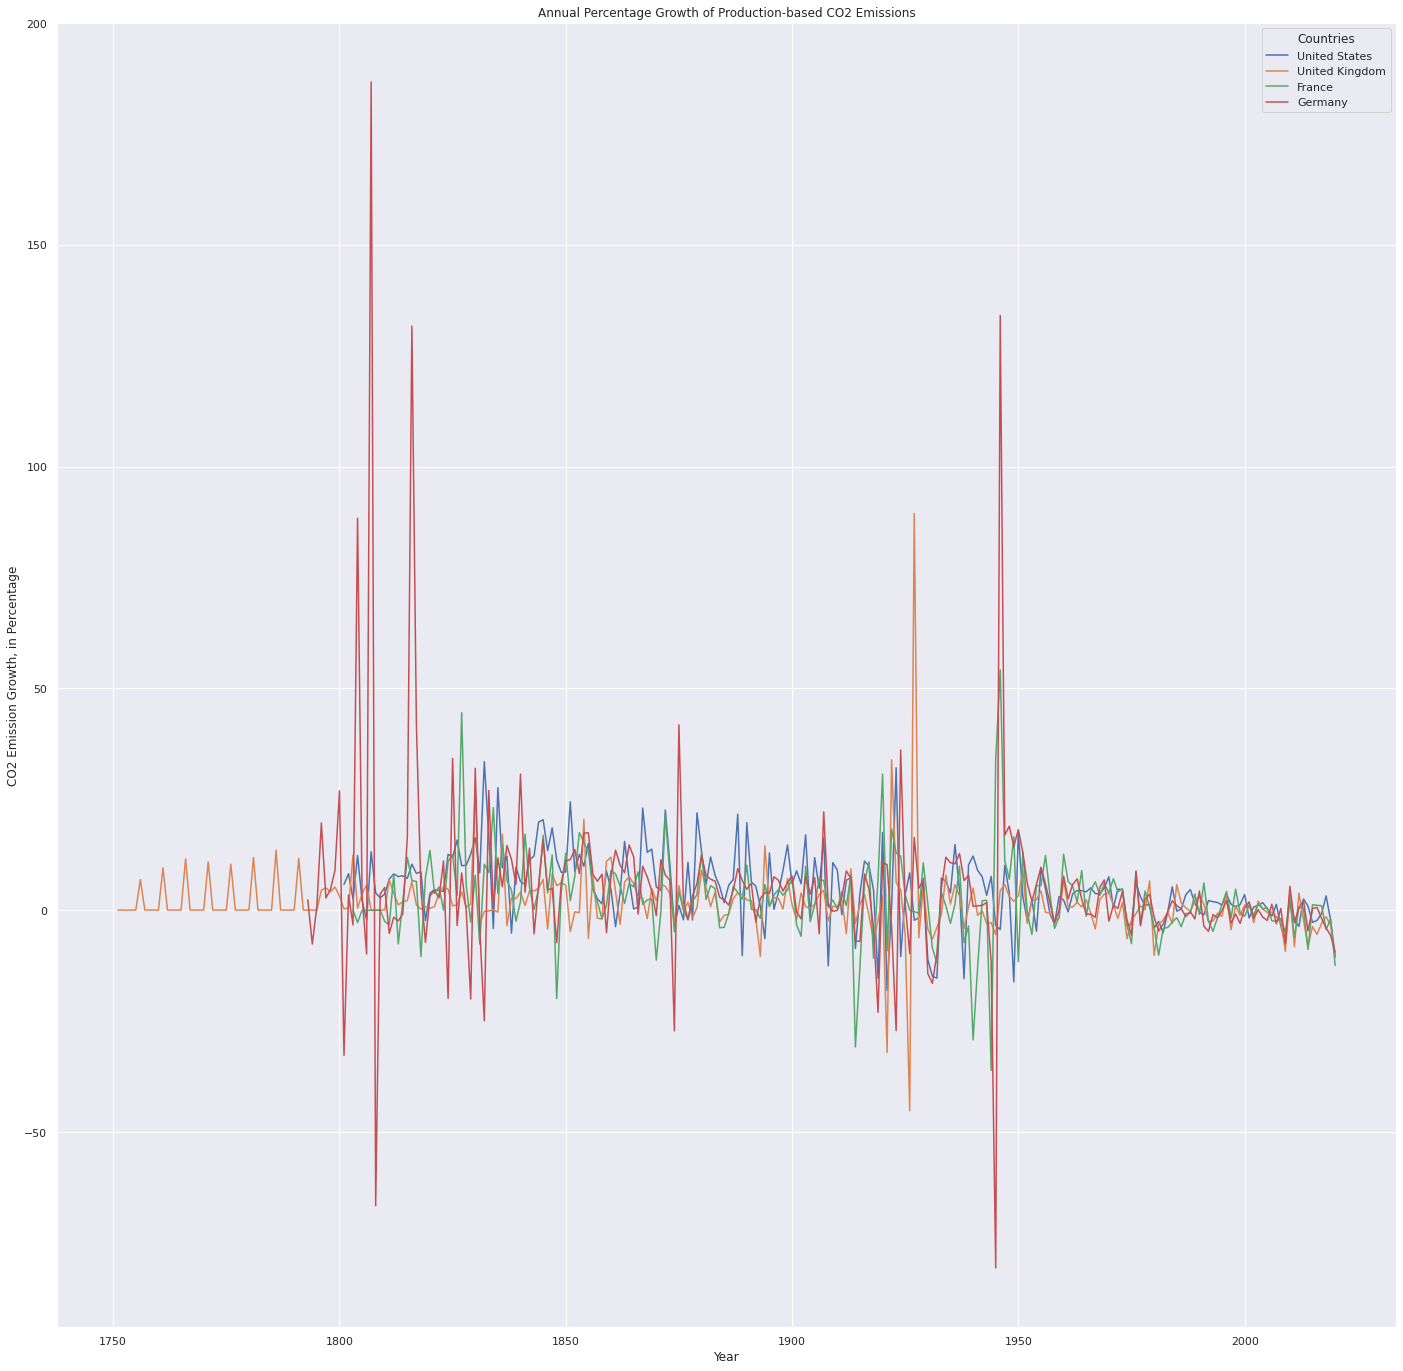

In [ ]:
plt.plot(d['year'], d['co2_growth_prct'], s['year'], s['co2_growth_prct'], f['year'], f['co2_growth_prct'], g['year'], g['co2_growth_prct'])
plt.xlabel('Year')
plt.ylabel('CO2 Emission Growth, in Percentage')
plt.legend( ['United States', 'United Kingdom', 'France', 'Germany'], title = 'Countries')
plt.title('Annual Percentage Growth of Production-based CO2 Emissions')
plt.show()

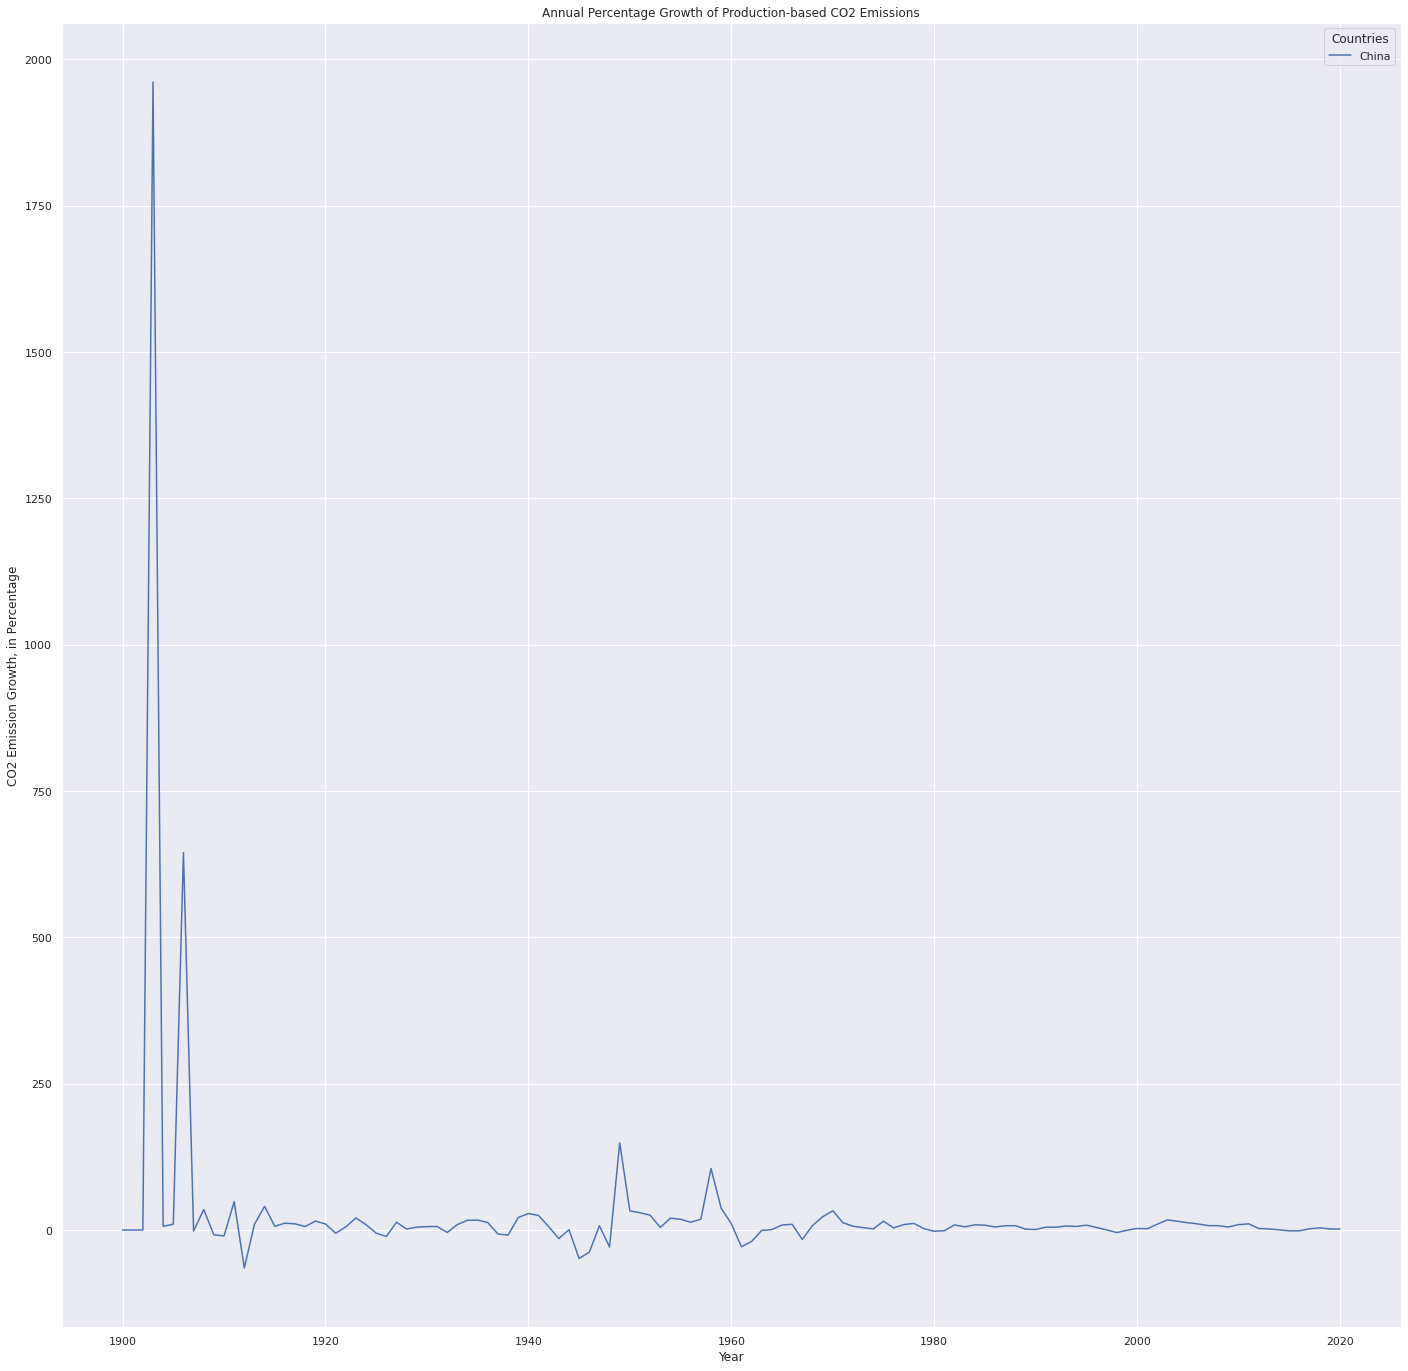

In [ ]:
plt.plot(c['year'], c['co2_growth_prct'])
plt.xlabel('Year')
plt.ylabel('CO2 Emission Growth, in Percentage')
plt.legend( ['China'], title = 'Countries')
plt.title('Annual Percentage Growth of Production-based CO2 Emissions')
plt.show()

In [ ]:
weatherFinal = pd.read_csv('Berkley_Weather_Final.csv')

FileNotFoundError: ignored

In [ ]:
dfe6['country'].nunique()

In [ ]:
weatherFinal['Country'].nunique()

In [ ]:
d = weatherFinal.loc[(weatherFinal['Country'] == 'United States')]
s = weatherFinal.loc[(weatherFinal['Country'] == 'United Kingdom')]
c = weatherFinal.loc[(weatherFinal['Country'] == 'China')]
f = weatherFinal.loc[(weatherFinal['Country'] == 'Australia')]
g = weatherFinal.loc[(weatherFinal['Country'] == 'India')]

plt.plot(d['Year'], d['Yearly Average Temperature'], s['Year'], s['Yearly Average Temperature'], c['Year'], c['Yearly Average Temperature'], f['Year'], f['Yearly Average Temperature'], g['Year'], g['Yearly Average Temperature'])
plt.xlabel('Year')
plt.ylabel('Yearly Average Temperature in Celsius')
plt.legend( ['United States', 'United Kingdom', 'China', 'Australia', 'India'], title = 'Countries')
plt.title('Yearly Average Temperature Over Time')
plt.show()

In [ ]:
cropsFinal = pd.read_csv('PSD_Grains_Final.csv')

In [ ]:
cropsFinal['Country_Name'].nunique()


In [ ]:
d = cropsFinal.loc[((cropsFinal['Country_Name'] == 'United States') & (cropsFinal['Commodity_Description'] == 'Wheat'))]
s = cropsFinal.loc[((cropsFinal['Country_Name'] == 'United Kingdom') & (cropsFinal['Commodity_Description'] == 'Wheat'))]
c = cropsFinal.loc[((cropsFinal['Country_Name'] == 'China') & (cropsFinal['Commodity_Description'] == 'Wheat'))]
f = cropsFinal.loc[((cropsFinal['Country_Name'] == 'Australia') & (cropsFinal['Commodity_Description'] == 'Wheat'))]
g = cropsFinal.loc[((cropsFinal['Country_Name'] == 'India') & (cropsFinal['Commodity_Description'] == 'Wheat'))]

plt.plot(d['Market_Year'], d['Imports'], s['Market_Year'], s['Imports'], c['Market_Year'], c['Imports'], f['Market_Year'], f['Imports'], g['Market_Year'], g['Imports'])
plt.xlabel('Market Year')
plt.ylabel('Total Imports of Wheat in Millions Tonnes')
plt.legend( ['United States', 'United Kingdom', 'China', 'Australia', 'India'], title = 'Countries')
plt.title('Imports of Wheat Over Time')
plt.show()

In [ ]:
d = cropsFinal.loc[((cropsFinal['Country_Name'] == 'United States') & (cropsFinal['Commodity_Description'] == 'Rice, Milled'))]
s = cropsFinal.loc[((cropsFinal['Country_Name'] == 'United Kingdom') & (cropsFinal['Commodity_Description'] == 'Rice, Milled'))]
c = cropsFinal.loc[((cropsFinal['Country_Name'] == 'China') & (cropsFinal['Commodity_Description'] == 'Rice, Milled'))]
f = cropsFinal.loc[((cropsFinal['Country_Name'] == 'Australia') & (cropsFinal['Commodity_Description'] == 'Rice, Milled'))]
g = cropsFinal.loc[((cropsFinal['Country_Name'] == 'India') & (cropsFinal['Commodity_Description'] == 'Rice, Milled'))]

plt.plot(d['Market_Year'], d['Imports'], s['Market_Year'], s['Imports'], c['Market_Year'], c['Imports'], f['Market_Year'], f['Imports'], g['Market_Year'], g['Imports'])
plt.xlabel('Market Year')
plt.ylabel('Total Imports of Rice (in Millions Tonnes')
plt.legend( ['United States', 'United Kingdom', 'China', 'Australia', 'India'], title = 'Countries')
plt.title('Imports of Rice Over Time')
plt.show()